# Installing Packages

# Importing Required Libraries

In [1]:
import torch
from torchtext import data, datasets
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pack_padded_sequence
from torchtext.data import Field, LabelField, BucketIterator

import random

import matplotlib.pyplot as plt

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Notebook is running on", device)

Notebook is running on cuda


Fixing SEED for reproducibility of results

In [3]:
SEED = 4444

random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
FIELD = Field(tokenize = 'spacy', tokenizer_language = 'en_core_web_sm', include_lengths=True)

LABEL = LabelField(dtype = torch.float)

# Splitting the data

In [5]:
train_data, test_data = datasets.IMDB.splits(FIELD, LABEL)

In [6]:
train_data, valid_data = train_data.split(random_state = random.seed(SEED))

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 17500
Number of validation examples: 7500
Number of testing examples: 25000


In [8]:
MAX_VOCAB_SIZE = 25000 # excluding <pad> and <unk> token

FIELD.build_vocab(train_data, max_size = MAX_VOCAB_SIZE, vectors="glove.6B.100d", unk_init = torch.Tensor.normal_)
LABEL.build_vocab(train_data)

In [9]:
print(f"Unique tokens in FIELD vocabulary: {len(FIELD.vocab)}")
print(f"Unique tokens in LABEL vocabulary: {len(LABEL.vocab)}")

Unique tokens in FIELD vocabulary: 25002
Unique tokens in LABEL vocabulary: 2


# Model Definition

In [10]:
class LSTM(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size, output_size, num_layers, pad_idx):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size, padding_idx = pad_idx)
        self.lstm = nn.LSTM(emb_size, hidden_size, num_layers = num_layers, bidirectional=True, dropout=0.5)
        self.fc = nn.Linear(hidden_size*2, output_size)
        self.dropout = nn.Dropout(0.5)
        
    def forward(self, input, input_lengths):                                                          # [input] = [seq_len, batch_size]
        embedded = self.dropout(self.embedding(input))                                                # [embedded] = [sent_len, batch_size, embedding_size]
        packed_embedded = pack_padded_sequence(embedded, input_lengths.to('cpu'))                     # inputs lengths need to be on CPU
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)
        # [output] = [seq_len, batch_size, hidden_size*2]
        # [hidden] = [num_layers * 2, batch_size, hidden_size]
        # [cell] = [num_layers * 2, batch_size, hidden_size]
        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))                   # [hidden] = [batch_size, hidden_size * 2]
        return self.fc(hidden)

In [11]:
def batch_accuracy(preds, y):

    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float()
    acc = correct.sum() / len(correct)
    return acc

# Training and Evaluation Functions

In [12]:
def Train(model, iterator, optimizer, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch in iterator:
        optimizer.zero_grad()
        inp, inp_lengths = batch.text
        label = batch.label       
        predictions = model(inp, inp_lengths).squeeze(1)
        loss = criterion(predictions, label)
        acc = batch_accuracy(predictions, label)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [13]:
def Evaluate(model, iterator, criterion):
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in iterator:
            inp, inp_lengths = batch.text
            label = batch.label       
            predictions = model(inp, inp_lengths).squeeze(1)
            loss = criterion(predictions, label)
            acc = batch_accuracy(predictions, label)
            epoch_loss += loss.item()
            epoch_acc += acc.item()
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

# Data Iterators, Hyperparameters and Model Initialization

In [14]:
BATCH_SIZE = 64

train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits((train_data, valid_data, test_data), batch_size = BATCH_SIZE, sort_within_batch = True, device = device)

In [15]:
VOCAB_SIZE = len(FIELD.vocab) # dimension of one-hot vector / vocabulary
EMB_DIM = 100 # dimension of word embeddings
HIDDEN_DIM = 256 # dimension of hidden layer
OUTPUT_DIM = 1 # dimension of output layer
NUM_LAYERS = 2

NUM_EPOCHS = 10
LR = 0.001

In [16]:
model = LSTM(VOCAB_SIZE, EMB_DIM, HIDDEN_DIM, OUTPUT_DIM, NUM_LAYERS, FIELD.vocab.stoi[FIELD.pad_token])

In [17]:
optimizer = optim.Adam(model.parameters(), lr=LR)

criterion = nn.BCEWithLogitsLoss()

model = model.to(device)
criterion = criterion.to(device)

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 4,810,857 trainable parameters


# Training

In [19]:
import time

def Epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
print(f"Learning Rate: {LR}, Hidden Dimensions: {HIDDEN_DIM}")
train_losses = []
valid_losses = []
min_losses = [float('inf'), float('inf')]

start_time = time.time()
for epoch in range(1, NUM_EPOCHS+1):
    
    train_loss, train_acc = Train(model, train_iterator, optimizer, criterion)
    train_losses.append(train_loss)
    valid_loss, valid_acc = Evaluate(model, valid_iterator, criterion)
    valid_losses.append(valid_loss)

    if valid_loss < min_losses[0]:
        min_losses[0] = valid_loss
        min_losses[1] = train_loss
        torch.save(model.state_dict(), 'LSTM.pt')

    elapsed_time = Epoch_time(start_time, time.time())
    print(f"Time taken for epoch {epoch}: {elapsed_time[0]}m {elapsed_time[1]}s")
    start_time = time.time()
    print(f"Training Loss: {train_loss:.4f} | Validation Loss: {valid_loss:.4f}")
    print(f"Training Accuracy: {train_acc*100:.2f} %| Validation Accuracy: {valid_acc*100:.2f} %")

print(f"Model with Train Loss {min_losses[1]:.4f}, Validation Loss: {min_losses[0]:.4f} was saved.")

Learning Rate: 0.001, Hidden Dimensions: 256
Time taken for epoch 1: 0m 35s
Training Loss: 0.6791 | Validation Loss: 0.7054
Training Accuracy: 56.48 %| Validation Accuracy: 52.33 %
Time taken for epoch 2: 0m 34s
Training Loss: 0.6756 | Validation Loss: 0.6665
Training Accuracy: 56.92 %| Validation Accuracy: 57.87 %
Time taken for epoch 3: 0m 35s
Training Loss: 0.6262 | Validation Loss: 0.5267
Training Accuracy: 64.63 %| Validation Accuracy: 74.09 %
Time taken for epoch 4: 0m 35s
Training Loss: 0.5106 | Validation Loss: 0.4333
Training Accuracy: 75.00 %| Validation Accuracy: 79.46 %
Time taken for epoch 5: 0m 35s
Training Loss: 0.4344 | Validation Loss: 0.3877
Training Accuracy: 80.39 %| Validation Accuracy: 82.77 %
Time taken for epoch 6: 0m 35s
Training Loss: 0.3672 | Validation Loss: 0.3312
Training Accuracy: 84.22 %| Validation Accuracy: 86.01 %
Time taken for epoch 7: 0m 35s
Training Loss: 0.3312 | Validation Loss: 0.3588
Training Accuracy: 86.08 %| Validation Accuracy: 84.35 %
Tim

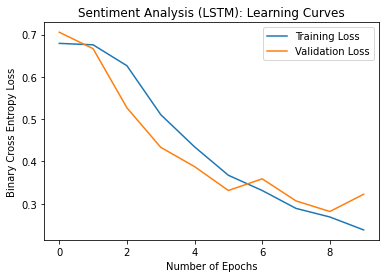

In [21]:
plt.title("Sentiment Analysis (LSTM): Learning Curves")
plt.xlabel("Number of Epochs")
plt.ylabel("Binary Cross Entropy Loss")
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label= "Validation Loss")
plt.legend()
plt.show()

# Testing

In [22]:
model.load_state_dict(torch.load('LSTM.pt'))

test_loss, test_acc = Evaluate(model, test_iterator, criterion)

print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_acc*100:.2f}%')

Test Loss: 0.2986
Test Accuracy: 87.62%


# Sampling

In [23]:
import spacy
nlp = spacy.load('en_core_web_sm')

def predict_sentiment(model, text):
    model.eval()
    tokenized = [tok.text for tok in nlp.tokenizer(text)]
    indexed = [FIELD.vocab.stoi[t] for t in tokenized]
    length = [len(indexed)]
    tensor = torch.LongTensor(indexed).to(device)
    tensor = tensor.unsqueeze(1)
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [24]:
predict_sentiment(model, "This film is not bad")

0.011234746314585209

In [25]:
predict_sentiment(model, "This film is excellent")

0.939202070236206

In [26]:
predict_sentiment(model, "This film is bad")

0.0072547681629657745